In [1]:
import matplotlib.pyplot as plt
import torch
from torch import nn
from torchvision import transforms as T
from torchvision import datasets
from torch.utils.data import DataLoader, Dataset, random_split
from torch.optim import Adam
from torch.optim.lr_scheduler import StepLR

import torchvision

from pathlib import Path
from tqdm import tqdm
import matplotlib.pyplot as plt
import copy
import os

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [3]:
DATASET_PATH = Path('D:/Dev/Datasets/FoodClassification')
PREPROC_PATH = Path('D:/Dev/Datasets/PreprocFoodClassification')
PREPROC_PATH.mkdir(parents=True, exist_ok=True)

In [4]:
# Transformations for the images
transform = T.Compose([
    T.Resize((224, 224)),
    T.ToTensor(),
    T.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

augmentation = T.Compose([
    T.Resize((224, 224)),
    # Data augmentation 
    T.RandomRotation(20),
    T.RandomResizedCrop((224, 224), scale=(0.7, 1), ratio=(1, 1)),
    
    T.ToTensor(),
    T.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

originalDataset = datasets.ImageFolder(root=DATASET_PATH)

In [5]:
for idx, (img, label) in enumerate(tqdm(originalDataset, desc=f"Processing images")):
    className = originalDataset.classes[label]
    classDir = PREPROC_PATH / className
    classDir.mkdir(parents=True, exist_ok=True)
    
    # Originals
    origImg = transform(img)
    origImgPath = classDir / f"{idx}_original.pt"
    torch.save((origImg, label), origImgPath)
    
    # Augmented
    augImg = augmentation(img)
    augImgPath = classDir / f"{idx}_aug.pt"
    torch.save((augImg, label), augImgPath)

Processing images:  59%|█████▉    | 3234/5481 [01:02<00:56, 39.70it/s]C:\Users\Peblo\AppData\Roaming\Python\Python310\site-packages\PIL\Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Processing images: 100%|██████████| 5481/5481 [01:42<00:00, 53.72it/s]


In [6]:
# Custom datasert to load the preprocessed data
class FoodDataset(Dataset):
    def __init__(self, root):
        self.root = Path(root)
        self.files = list(self.root.glob("**/*.pt"))
        self.classes = os.listdir(self.root)

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        imgTensor, label = torch.load(self.files[idx])
        return imgTensor, label

dataset = FoodDataset(PREPROC_PATH)


In [7]:
CLASSES = dataset.classes
NUM_CLASES = len(CLASSES)

print(NUM_CLASES, CLASSES)

15 ['apple_pie', 'baked_potato', 'burger', 'cheesecake', 'crispy_chicken', 'donut', 'fried_rice', 'fries', 'hot_dog', 'ice_cream', 'omelette', 'pizza', 'sandwich', 'sushi', 'taco']


In [8]:
# Perform the split into training and validation
trainSize = int(0.8 * len(dataset))
valSize = len(dataset) - trainSize
trainDataset, valDataset = random_split(dataset, [trainSize, valSize])

In [9]:
# Create the loaders
trainLoader = DataLoader(trainDataset, batch_size=32, shuffle=True, pin_memory=True)
valLoader = DataLoader(valDataset, batch_size=32, shuffle=False, pin_memory=True)
originalLoader = DataLoader(originalDataset, batch_size=32, shuffle=True)

In [10]:
def PlotImages(loader):
    images, labels = next(iter(loader))
    images = images.cpu().numpy()
    labels = labels.cpu().numpy()

    fig, axes = plt.subplots(4, 6, figsize=(15, 10)) 
    axes = axes.flatten()

    for ax, img, label in zip(axes, images, labels):
        img = (img.transpose(1, 2, 0) + 1) / 2
        ax.imshow(img)
        ax.axis('off')
        ax.set_title(CLASSES[label])

    plt.tight_layout()
    plt.show()

C:\Users\Peblo\AppData\Local\Temp\ipykernel_24532\2689297585.py:12: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  imgTensor, label = torch.load(self.files[idx])


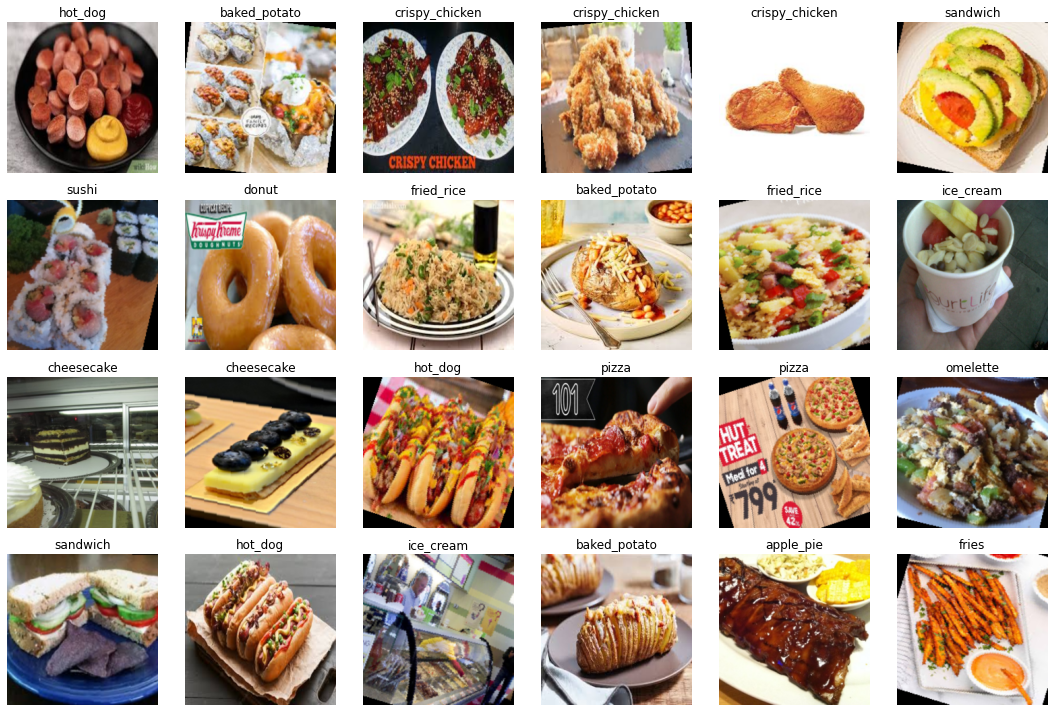

In [11]:
PlotImages(trainLoader)

In [15]:
class Bottleneck(nn.Module):
    def __init__(self, inChan, outChan, expansion=4, stride=1):
        super().__init__()

        midChan = outChan // expansion

        self.convBlock = nn.Sequential(
            nn.Conv2d(inChan, midChan, kernel_size=1, stride=1, bias=False),
            nn.BatchNorm2d(midChan),
            nn.ReLU(inplace=True),

            nn.Conv2d(midChan, midChan, kernel_size=3, stride=stride, padding=1, bias=False),
            nn.BatchNorm2d(midChan),
            nn.ReLU(inplace=True),

            nn.Conv2d(midChan, outChan, kernel_size=1, stride=1, bias=False),
            nn.BatchNorm2d(outChan),
        )

        self.downsample = None

        if inChan != outChan or stride != 1:
            self.downsample = nn.Sequential(
                nn.Conv2d(inChan, outChan, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(outChan)
            ) 

        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        out = self.convBlock(x)

        skip = x
        if self.downsample:
            skip = self.downsample(x)

        out += skip
        out = self.relu(out)

        return out


In [56]:
# Kinda Resnet50
model = nn.Sequential(
    nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False),
    nn.BatchNorm2d(64),
    nn.ReLU(inplace=True),
    nn.MaxPool2d(2, stride=2),

    # Stage 1
    Bottleneck(64, 256, stride=1),
    Bottleneck(256, 256, stride=1),
    Bottleneck(256, 256, stride=1),

    # Stage 2
    Bottleneck(256, 512, stride=2),
    Bottleneck(512, 512, stride=1),
    Bottleneck(512, 512, stride=1),
    Bottleneck(512, 512, stride=1),

    # Stage 3
    Bottleneck(512, 1024, stride=2),
    Bottleneck(1024, 1024, stride=1),
    Bottleneck(1024, 1024, stride=1),
    Bottleneck(1024, 1024, stride=1),
    Bottleneck(1024, 1024, stride=1),
    Bottleneck(1024, 1024, stride=1),

    # Stage 4
    Bottleneck(1024, 2048, stride=2),
    Bottleneck(2048, 2048, stride=1),
    Bottleneck(2048, 2048, stride=1),

    nn.AdaptiveAvgPool2d(output_size=(1, 1)),
    nn.Flatten(),
    nn.Linear(2048, 256),
    nn.ReLU(),
    nn.Linear(256, NUM_CLASES),
)

In [57]:
model.to(device)
print(model)

Sequential(
  (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (4): Bottleneck(
    (convBlock): Sequential(
      (0): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
      (6): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (7): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (downsample): Sequential(
      (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(

In [ ]:
trainLosses = []
trainAcc = []
valLosses = []
valAcc = []

bestLoss = float('inf')
bestModelWeights = None

In [63]:
lossFunc = nn.CrossEntropyLoss()
optimizer = Adam(model.parameters())
scheduler = StepLR(optimizer, step_size=10, gamma=0.5)

patience = 30

def getBatchAccuracy(output, y):
    pred = output.argmax(dim=1, keepdim=True)
    correct = pred.eq(y.view_as(pred)).sum().item()
    return correct / len(y)

def validate():
    valLoss = 0
    correct = 0
    model.eval()

    with torch.no_grad():
        for x, y in valLoader:
            x, y = x.to(device), y.to(device)
            output = model(x)

            valLoss += lossFunc(output, y).item() * x.size(0)
            correct += getBatchAccuracy(output, y) * x.size(0)

    avgLoss = valLoss / valSize
    accuracy = correct / valSize

    valLosses.append(avgLoss)
    valAcc.append(accuracy)

    print(f'(val) Loss: {avgLoss:.4f} Accuracy: {accuracy:.4f}')

    global bestLoss, bestModelWeights, patience

    if valLoss < bestLoss:
        bestLoss = valLoss
        bestModelWeights = copy.deepcopy(model.state_dict())
        patience = 10

    else:
        patience -= 1
        if patience == 0:
            return True
        
    return False

def train():
    trainLoss = 0
    correct = 0
    model.train()
    
    for x, y in trainLoader:
        x, y = x.to(device), y.to(device)
        output = model(x)
        optimizer.zero_grad()
        batchLoss = lossFunc(output, y)
        batchLoss.backward()
        optimizer.step()

        trainLoss += batchLoss.item() * x.size(0)
        correct += getBatchAccuracy(output, y) * x.size(0)

    avgLoss = trainLoss / trainSize
    accuracy = correct / trainSize

    trainLosses.append(avgLoss)
    trainAcc.append(accuracy)

    print(f'(train) Loss: {avgLoss:.4f} Accuracy: {accuracy:.4f}')

In [64]:
epochs = 100

# Train the model
for epoch in range(100, 300):
    print(f'Epoch {epoch}')
    train()
    if validate(): 
        break # Early stopping
    
    scheduler.step()

Epoch 100
(train) Loss: 2.3593 Accuracy: 0.2634
(val) Loss: 2.4038 Accuracy: 0.2263
Epoch 101
(train) Loss: 2.3536 Accuracy: 0.2630
(val) Loss: 2.3779 Accuracy: 0.2737
Epoch 102
(train) Loss: 2.3407 Accuracy: 0.2701
(val) Loss: 2.3266 Accuracy: 0.2413
Epoch 103
(train) Loss: 2.3452 Accuracy: 0.2628
(val) Loss: 2.3318 Accuracy: 0.2492
Epoch 104
(train) Loss: 2.3469 Accuracy: 0.2754
(val) Loss: 2.3485 Accuracy: 0.2737
Epoch 105
(train) Loss: 2.3384 Accuracy: 0.2668
(val) Loss: 2.3306 Accuracy: 0.2539
Epoch 106
(train) Loss: 2.3238 Accuracy: 0.2608
(val) Loss: 2.3303 Accuracy: 0.2729
Epoch 107
(train) Loss: 2.3285 Accuracy: 0.2798
(val) Loss: 2.3942 Accuracy: 0.2153
Epoch 108
(train) Loss: 2.3343 Accuracy: 0.2569
(val) Loss: 2.4113 Accuracy: 0.2177
Epoch 109
(train) Loss: 2.3212 Accuracy: 0.2666
(val) Loss: 2.3358 Accuracy: 0.2626
Epoch 110
(train) Loss: 2.3005 Accuracy: 0.2948
(val) Loss: 2.3061 Accuracy: 0.2697
Epoch 111
(train) Loss: 2.2850 Accuracy: 0.2861
(val) Loss: 2.2909 Accuracy:

In [ ]:
model.load_state_dict(bestModelWeights)

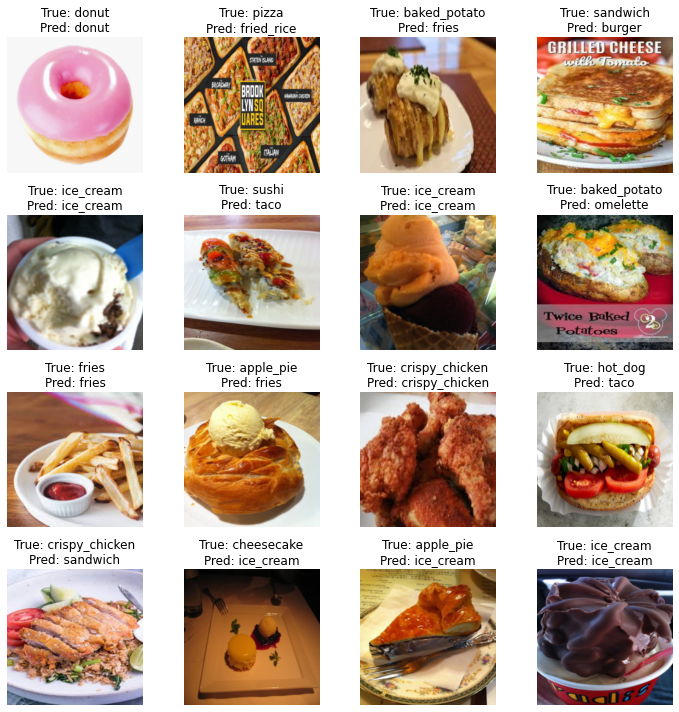

In [68]:
# Print the model predictions
model.eval()
images, labels = next(iter(valLoader))

images = images.to(device)
labels = labels.to(device)

with torch.no_grad():
    outputs = model(images)
    _, preds = torch.max(outputs, 1)

images = images.cpu().numpy()
labels = labels.cpu().numpy()
preds = preds.cpu().numpy()

fig, axes = plt.subplots(4, 4, figsize=(10, 10))
axes = axes.flatten()

for ax, img, label, pred in zip(axes, images, labels, preds):
    img = (img.transpose(1, 2, 0) + 1) / 2
    ax.imshow(img)
    ax.axis('off')
    ax.set_title(f'True: {CLASSES[label]}\nPred: {CLASSES[pred]}')

plt.tight_layout()
plt.show()

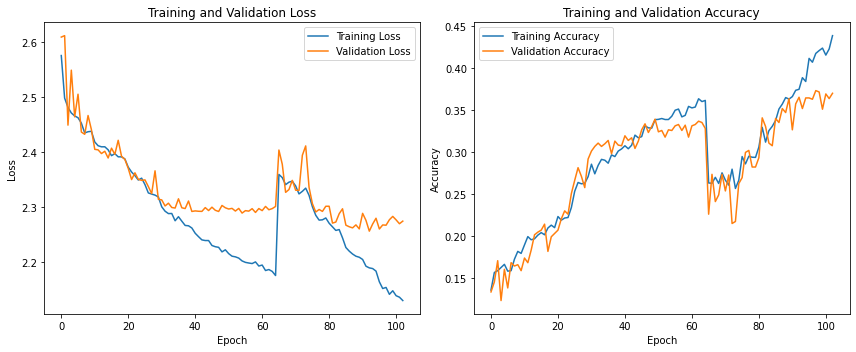

In [69]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(trainLosses, label='Training Loss')
plt.plot(valLosses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(trainAcc, label='Training Accuracy')
plt.plot(valAcc, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [25]:
# Save the model
torch.save(model.state_dict(), Path('../prototypes/FCModel.pth'))

In [13]:
# Run with transfer learning

# Load the model
model = torchvision.models.resnet50(torchvision.models.ResNet50_Weights.DEFAULT)

In [14]:
model.fc = nn.Sequential(
    nn.Linear(2048, 256),
    nn.ReLU(),
    nn.Linear(256, NUM_CLASES),
)

for param in model.fc.parameters():
    param.requires_grad = True

for param in model.layer4.parameters():
    param.requires_grad = True

In [15]:
model.to(device)
print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [16]:
lossFunc = nn.CrossEntropyLoss()
optimizer = Adam(model.parameters())
scheduler = StepLR(optimizer, step_size=10, gamma=0.5)

trainLosses = []
trainAcc = []
valLosses = []
valAcc = []

bestLoss = float('inf')
bestModelWeights = None
patience = 10

def getBatchAccuracy(output, y):
    pred = output.argmax(dim=1, keepdim=True)
    correct = pred.eq(y.view_as(pred)).sum().item()
    return correct / len(y)

def validate():
    valLoss = 0
    correct = 0
    model.eval()

    with torch.no_grad():
        for x, y in valLoader:
            x, y = x.to(device), y.to(device)
            output = model(x)

            valLoss += lossFunc(output, y).item() * x.size(0)
            correct += getBatchAccuracy(output, y) * x.size(0)

    avgLoss = valLoss / valSize
    accuracy = correct / valSize

    valLosses.append(avgLoss)
    valAcc.append(accuracy)

    print(f'(val) Loss: {avgLoss:.4f} Accuracy: {accuracy:.4f}')

    global bestLoss, bestModelWeights, patience

    if valLoss < bestLoss:
        bestLoss = valLoss
        bestModelWeights = copy.deepcopy(model.state_dict())
        patience = 10

    else:
        patience -= 1
        if patience == 0:
            return True
        
    return False

def train():
    trainLoss = 0
    correct = 0
    model.train()
    
    for x, y in trainLoader:
        x, y = x.to(device), y.to(device)
        output = model(x)
        optimizer.zero_grad()
        batchLoss = lossFunc(output, y)
        batchLoss.backward()
        optimizer.step()

        trainLoss += batchLoss.item() * x.size(0)
        correct += getBatchAccuracy(output, y) * x.size(0)

    avgLoss = trainLoss / trainSize
    accuracy = correct / trainSize

    trainLosses.append(avgLoss)
    trainAcc.append(accuracy)

    print(f'(train) Loss: {avgLoss:.4f} Accuracy: {accuracy:.4f}')

In [17]:
epochs = 50

# Train the model
for epoch in range(epochs):
    print(f'Epoch {epoch}')
    train()
    if validate(): 
        break # Early stopping
    
    scheduler.step()

Epoch 0


C:\Users\Peblo\AppData\Local\Temp\ipykernel_24532\2689297585.py:12: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  imgTensor, label = torch.load(self.files[idx])


(train) Loss: 1.0076 Accuracy: 0.6897
(val) Loss: 0.9535 Accuracy: 0.7045
Epoch 1
(train) Loss: 0.5044 Accuracy: 0.8416
(val) Loss: 0.8634 Accuracy: 0.7342
Epoch 2
(train) Loss: 0.3363 Accuracy: 0.8885
(val) Loss: 0.6605 Accuracy: 0.8076
Epoch 3
(train) Loss: 0.2813 Accuracy: 0.9108
(val) Loss: 0.6854 Accuracy: 0.8035
Epoch 4
(train) Loss: 0.2008 Accuracy: 0.9371
(val) Loss: 0.8760 Accuracy: 0.7583
Epoch 5
(train) Loss: 0.2281 Accuracy: 0.9255
(val) Loss: 0.4221 Accuracy: 0.8682
Epoch 6
(train) Loss: 0.1548 Accuracy: 0.9504
(val) Loss: 0.4974 Accuracy: 0.8564
Epoch 7
(train) Loss: 0.1274 Accuracy: 0.9579
(val) Loss: 0.4972 Accuracy: 0.8668
Epoch 8
(train) Loss: 0.1627 Accuracy: 0.9506
(val) Loss: 0.4413 Accuracy: 0.8691
Epoch 9
(train) Loss: 0.1392 Accuracy: 0.9527
(val) Loss: 0.5204 Accuracy: 0.8554
Epoch 10
(train) Loss: 0.0370 Accuracy: 0.9879
(val) Loss: 0.2962 Accuracy: 0.9220
Epoch 11
(train) Loss: 0.0124 Accuracy: 0.9969
(val) Loss: 0.2884 Accuracy: 0.9284
Epoch 12
(train) Loss:

In [18]:
model.load_state_dict(bestModelWeights)

<All keys matched successfully>

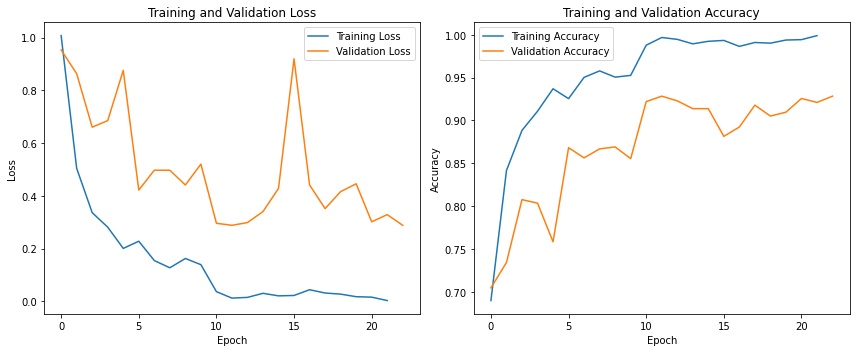

In [20]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(trainLosses, label='Training Loss')
plt.plot(valLosses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(trainAcc, label='Training Accuracy')
plt.plot(valAcc, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

C:\Users\Peblo\AppData\Local\Temp\ipykernel_24532\2689297585.py:12: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  imgTensor, label = torch.load(self.files[idx])


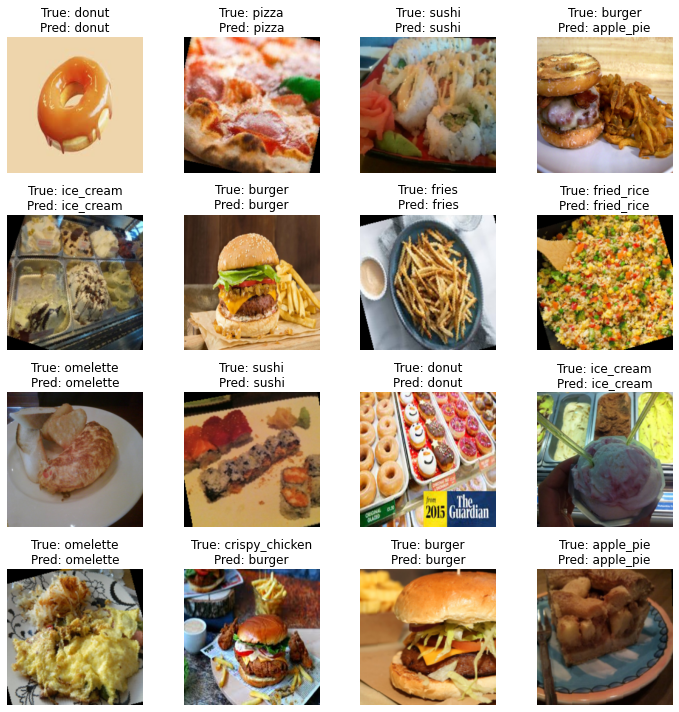

In [21]:
# Print the model predictions
model.eval()
images, labels = next(iter(valLoader))

images = images.to(device)
labels = labels.to(device)

with torch.no_grad():
    outputs = model(images)
    _, preds = torch.max(outputs, 1)

images = images.cpu().numpy()
labels = labels.cpu().numpy()
preds = preds.cpu().numpy()

fig, axes = plt.subplots(4, 4, figsize=(10, 10))
axes = axes.flatten()

for ax, img, label, pred in zip(axes, images, labels, preds):
    img = (img.transpose(1, 2, 0) + 1) / 2
    ax.imshow(img)
    ax.axis('off')
    ax.set_title(f'True: {CLASSES[label]}\nPred: {CLASSES[pred]}')

plt.tight_layout()
plt.show()

In [22]:
torch.save(model.state_dict(), Path('FoodClassModel2.pt'))